In [1]:
import numpy as np
import pandas as pd
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.exceptions import InvalidSignature
import base64
import hashlib
import os
from tqdm import tqdm

def generate_synthetic_dataset(num_samples=10000, forgery_ratio=0.5):
    """
    Generate a synthetic dataset of digital signatures with both legitimate and forged examples.

    Parameters:
    - num_samples: Total number of samples to generate
    - forgery_ratio: Proportion of samples that should be forged signatures

    Returns:
    - DataFrame containing signature data and labels
    """
    print("Generating synthetic dataset...")

    # Calculate number of legitimate and forged samples
    num_legitimate = int(num_samples * (1 - forgery_ratio))
    num_forged = num_samples - num_legitimate

    data = []

    # Generate legitimate signatures
    print("Generating legitimate signatures...")
    for i in tqdm(range(num_legitimate)):
        # Generate a new key pair for each legitimate signature to simulate different users
        private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048
        )
        public_key = private_key.public_key()

        # Generate random document data
        document = os.urandom(np.random.randint(100, 1000))
        document_hash = hashlib.sha256(document).hexdigest()

        # Sign the document
        signature = private_key.sign(
            document,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )

        # Extract features from the signature
        signature_bytes = base64.b64encode(signature).decode('utf-8')
        signature_length = len(signature)

        # Additional features based on the signature properties
        entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                          for p in [signature.count(i)/len(signature) for i in range(256)]])
        distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1

        data.append({
            'document_hash': document_hash,
            'signature_length': signature_length,
            'signature_entropy': entropy,
            'signature_skewness': distribution_skewness,
            'signing_time_ms': np.random.normal(150, 25),  # Simulated signing time
            'key_strength': 2048,
            'signature_algorithm': 'RSA-PSS-SHA256',
            'is_forged': 0
        })

    # Generate forged signatures
    print("Generating forged signatures...")
    for i in tqdm(range(num_forged)):
        # Create several types of forgeries
        forgery_type = np.random.randint(0, 4)

        if forgery_type == 0:
            # Type 1: Completely random invalid signature
            signature = os.urandom(np.random.randint(245, 256))  # RSA-2048 produces ~256 byte signatures
            document_hash = hashlib.sha256(os.urandom(np.random.randint(100, 1000))).hexdigest()
            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1

            # Forged signatures may have unusual characteristics
            signing_time = np.random.choice([
                np.random.normal(20, 5),      # Suspiciously fast
                np.random.normal(500, 100)    # Suspiciously slow
            ])

        elif forgery_type == 1:
            # Type 2: Tampered signature (bit flipping)
            # Start with a legitimate signature and modify it
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )
            document = os.urandom(np.random.randint(100, 1000))
            document_hash = hashlib.sha256(document).hexdigest()

            signature = bytearray(private_key.sign(
                document,
                padding.PSS(
                    mgf=padding.MGF1(hashes.SHA256()),
                    salt_length=padding.PSS.MAX_LENGTH
                ),
                hashes.SHA256()
            ))

            # Tamper with the signature by flipping some bits
            num_bits_to_flip = np.random.randint(1, 5)
            for _ in range(num_bits_to_flip):
                pos = np.random.randint(0, len(signature))
                bit_pos = np.random.randint(0, 8)
                signature[pos] = signature[pos] ^ (1 << bit_pos)

            signature = bytes(signature)
            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)  # Normal signing time

        elif forgery_type == 2:
            # Type 3: Signature from a different document
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )

            # Generate two different documents
            document1 = os.urandom(np.random.randint(100, 1000))
            document2 = os.urandom(np.random.randint(100, 1000))

            # Hash of document we claim to be signing
            document_hash = hashlib.sha256(document1).hexdigest()

            # But signature is from different document
            signature = private_key.sign(
                document2,
                padding.PSS(
                    mgf=padding.MGF1(hashes.SHA256()),
                    salt_length=padding.PSS.MAX_LENGTH
                ),
                hashes.SHA256()
            )

            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)

        else:
            # Type 4: Weak key forgery (using obsolete parameters)
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=1024  # Weaker key size
            )
            document = os.urandom(np.random.randint(100, 1000))
            document_hash = hashlib.sha256(document).hexdigest()

            signature = private_key.sign(
                document,
                padding.PKCS1v15(),  # Older padding scheme
                hashes.SHA1()        # Weaker hash algorithm
            )

            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)

        data.append({
            'document_hash': document_hash,
            'signature_length': signature_length,
            'signature_entropy': entropy,
            'signature_skewness': distribution_skewness,
            'signing_time_ms': signing_time,
            'key_strength': 1024 if forgery_type == 3 else 2048,
            'signature_algorithm': 'RSA-PKCS1v15-SHA1' if forgery_type == 3 else 'RSA-PSS-SHA256',
            'is_forged': 1,
            'forgery_type': ['random', 'tampered', 'document_mismatch', 'weak_params'][forgery_type]
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Add some derived features
    df['entropy_length_ratio'] = df['signature_entropy'] / df['signature_length']
    df['length_normalized'] = df['signature_length'] / df['signature_length'].mean()

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)

    print(f"Dataset generated with {num_legitimate} legitimate and {num_forged} forged signatures.")
    return df

# Generate and save the dataset
if __name__ == "__main__":
    dataset = generate_synthetic_dataset(num_samples=10000, forgery_ratio=0.5)
    dataset.to_csv("digital_signature_dataset.csv", index=False)
    print("Dataset saved to digital_signature_dataset.csv")

    # Display dataset statistics
    print("\nDataset Statistics:")
    print(f"Total samples: {len(dataset)}")
    print(f"Legitimate signatures: {len(dataset[dataset['is_forged'] == 0])}")
    print(f"Forged signatures: {len(dataset[dataset['is_forged'] == 1])}")

    if 'forgery_type' in dataset.columns:
        forgery_counts = dataset[dataset['is_forged'] == 1]['forgery_type'].value_counts()
        print("\nForgery Types:")
        for ftype, count in forgery_counts.items():
            print(f"  - {ftype}: {count}")

Generating synthetic dataset...
Generating legitimate signatures...


100%|██████████| 5000/5000 [07:22<00:00, 11.29it/s]


Generating forged signatures...


100%|██████████| 5000/5000 [03:35<00:00, 23.19it/s]

Dataset generated with 5000 legitimate and 5000 forged signatures.
Dataset saved to digital_signature_dataset.csv

Dataset Statistics:
Total samples: 10000
Legitimate signatures: 5000
Forged signatures: 5000

Forgery Types:
  - document_mismatch: 1268
  - weak_params: 1255
  - tampered: 1254
  - random: 1223


Exploring the Data to gain Insights


In [2]:
import numpy as np
import pandas as pd
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.exceptions import InvalidSignature
import base64
import hashlib
import os
from tqdm import tqdm

def generate_synthetic_dataset(num_samples=10000, forgery_ratio=0.5):
    """
    Generate a synthetic dataset of digital signatures with both legitimate and forged examples.

    Parameters:
    - num_samples: Total number of samples to generate
    - forgery_ratio: Proportion of samples that should be forged signatures

    Returns:
    - DataFrame containing signature data and labels
    """
    print("Generating synthetic dataset...")

    # Calculate number of legitimate and forged samples
    num_legitimate = int(num_samples * (1 - forgery_ratio))
    num_forged = num_samples - num_legitimate

    data = []

    # Generate legitimate signatures
    print("Generating legitimate signatures...")
    for i in tqdm(range(num_legitimate)):
        # Generate a new key pair for each legitimate signature to simulate different users
        private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048
        )
        public_key = private_key.public_key()

        # Generate random document data
        document = os.urandom(np.random.randint(100, 1000))
        document_hash = hashlib.sha256(document).hexdigest()

        # Sign the document
        signature = private_key.sign(
            document,
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.MAX_LENGTH
            ),
            hashes.SHA256()
        )

        # Extract features from the signature
        signature_bytes = base64.b64encode(signature).decode('utf-8')
        signature_length = len(signature)

        # Additional features based on the signature properties
        entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                          for p in [signature.count(i)/len(signature) for i in range(256)]])
        distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1

        data.append({
            'document_hash': document_hash,
            'signature_length': signature_length,
            'signature_entropy': entropy,
            'signature_skewness': distribution_skewness,
            'signing_time_ms': np.random.normal(150, 25),  # Simulated signing time
            'key_strength': 2048,
            'signature_algorithm': 'RSA-PSS-SHA256',
            'is_forged': 0
        })

    # Generate forged signatures
    print("Generating forged signatures...")
    for i in tqdm(range(num_forged)):
        # Create several types of forgeries
        forgery_type = np.random.randint(0, 4)

        if forgery_type == 0:
            # Type 1: Completely random invalid signature
            signature = os.urandom(np.random.randint(245, 256))  # RSA-2048 produces ~256 byte signatures
            document_hash = hashlib.sha256(os.urandom(np.random.randint(100, 1000))).hexdigest()
            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1

            # Forged signatures may have unusual characteristics
            signing_time = np.random.choice([
                np.random.normal(20, 5),      # Suspiciously fast
                np.random.normal(500, 100)    # Suspiciously slow
            ])

        elif forgery_type == 1:
            # Type 2: Tampered signature (bit flipping)
            # Start with a legitimate signature and modify it
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )
            document = os.urandom(np.random.randint(100, 1000))
            document_hash = hashlib.sha256(document).hexdigest()

            signature = bytearray(private_key.sign(
                document,
                padding.PSS(
                    mgf=padding.MGF1(hashes.SHA256()),
                    salt_length=padding.PSS.MAX_LENGTH
                ),
                hashes.SHA256()
            ))

            # Tamper with the signature by flipping some bits
            num_bits_to_flip = np.random.randint(1, 5)
            for _ in range(num_bits_to_flip):
                pos = np.random.randint(0, len(signature))
                bit_pos = np.random.randint(0, 8)
                signature[pos] = signature[pos] ^ (1 << bit_pos)

            signature = bytes(signature)
            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)  # Normal signing time

        elif forgery_type == 2:
            # Type 3: Signature from a different document
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=2048
            )

            # Generate two different documents
            document1 = os.urandom(np.random.randint(100, 1000))
            document2 = os.urandom(np.random.randint(100, 1000))

            # Hash of document we claim to be signing
            document_hash = hashlib.sha256(document1).hexdigest()

            # But signature is from different document
            signature = private_key.sign(
                document2,
                padding.PSS(
                    mgf=padding.MGF1(hashes.SHA256()),
                    salt_length=padding.PSS.MAX_LENGTH
                ),
                hashes.SHA256()
            )

            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)

        else:
            # Type 4: Weak key forgery (using obsolete parameters)
            private_key = rsa.generate_private_key(
                public_exponent=65537,
                key_size=1024  # Weaker key size
            )
            document = os.urandom(np.random.randint(100, 1000))
            document_hash = hashlib.sha256(document).hexdigest()

            signature = private_key.sign(
                document,
                padding.PKCS1v15(),  # Older padding scheme
                hashes.SHA1()        # Weaker hash algorithm
            )

            signature_length = len(signature)
            entropy = np.sum([-p * np.log2(p) if p > 0 else 0
                             for p in [signature.count(i)/len(signature) for i in range(256)]])
            distribution_skewness = np.mean([signature[i] for i in range(len(signature))]) / 128 - 1
            signing_time = np.random.normal(150, 25)

        data.append({
            'document_hash': document_hash,
            'signature_length': signature_length,
            'signature_entropy': entropy,
            'signature_skewness': distribution_skewness,
            'signing_time_ms': signing_time,
            'key_strength': 1024 if forgery_type == 3 else 2048,
            'signature_algorithm': 'RSA-PKCS1v15-SHA1' if forgery_type == 3 else 'RSA-PSS-SHA256',
            'is_forged': 1,
            'forgery_type': ['random', 'tampered', 'document_mismatch', 'weak_params'][forgery_type]
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Add some derived features
    df['entropy_length_ratio'] = df['signature_entropy'] / df['signature_length']
    df['length_normalized'] = df['signature_length'] / df['signature_length'].mean()

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)

    print(f"Dataset generated with {num_legitimate} legitimate and {num_forged} forged signatures.")
    return df

# Generate and save the dataset
if __name__ == "__main__":
    dataset = generate_synthetic_dataset(num_samples=10000, forgery_ratio=0.5)
    dataset.to_csv("digital_signature_dataset.csv", index=False)
    print("Dataset saved to digital_signature_dataset.csv")

    # Display dataset statistics
    print("\nDataset Statistics:")
    print(f"Total samples: {len(dataset)}")
    print(f"Legitimate signatures: {len(dataset[dataset['is_forged'] == 0])}")
    print(f"Forged signatures: {len(dataset[dataset['is_forged'] == 1])}")

    if 'forgery_type' in dataset.columns:
        forgery_counts = dataset[dataset['is_forged'] == 1]['forgery_type'].value_counts()
        print("\nForgery Types:")
        for ftype, count in forgery_counts.items():
            print(f"  - {ftype}: {count}")

Generating synthetic dataset...
Generating legitimate signatures...


100%|██████████| 5000/5000 [06:39<00:00, 12.52it/s]


Generating forged signatures...


100%|██████████| 5000/5000 [03:39<00:00, 22.81it/s]


Dataset generated with 5000 legitimate and 5000 forged signatures.
Dataset saved to digital_signature_dataset.csv

Dataset Statistics:
Total samples: 10000
Legitimate signatures: 5000
Forged signatures: 5000

Forgery Types:
  - random: 1286
  - document_mismatch: 1283
  - weak_params: 1254
  - tampered: 1177


Prepare the data


In [3]:
  import pandas as pd
  import numpy as np
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, OneHotEncoder
  from sklearn.impute import SimpleImputer
  from sklearn.pipeline import Pipeline
  from sklearn.compose import ColumnTransformer

  def prepare_data(df, test_size=0.2, random_state=42):
      """
      Prepare the dataset for machine learning by cleaning, feature engineering,
      and splitting into training and testing sets.

      Parameters:
      - df: pandas DataFrame containing the digital signature dataset
      - test_size: proportion of data to use for testing
      - random_state: random seed for reproducibility

      Returns:
      - X_train, X_test, y_train, y_test: prepared train/test split data
      - preprocessor: fitted preprocessing pipeline for later use
      """
      print("Preparing data for model training...")

      # Make a copy of the data to avoid modifying the original
      df_copy = df.copy()

      # Handle missing values if any
      if df_copy.isnull().sum().sum() > 0:
          print(f"Handling {df_copy.isnull().sum().sum()} missing values...")
          # For this dataset, we're likely to have minimal missing values,
          # but we'll implement a strategy anyway
          numeric_imputer = SimpleImputer(strategy='median')
          categorical_imputer = SimpleImputer(strategy='most_frequent')

          df_copy.loc[:, df_copy.select_dtypes(include=[np.number]).columns] = numeric_imputer.fit_transform(
              df_copy.select_dtypes(include=[np.number])
          )

          if not df_copy.select_dtypes(include=['object']).empty:
              df_copy.loc[:, df_copy.select_dtypes(include=['object']).columns] = categorical_imputer.fit_transform(
                  df_copy.select_dtypes(include=['object'])
              )

      # Feature engineering
      print("Performing feature engineering...")

      # 1. Create ratio features
      if 'signature_entropy' in df_copy.columns and 'signature_length' in df_copy.columns:
          df_copy['entropy_per_byte'] = df_copy['signature_entropy'] / df_copy['signature_length']

      # 2. Create binary indicators
      if 'key_strength' in df_copy.columns:
          df_copy['is_weak_key'] = (df_copy['key_strength'] < 2048).astype(int)

      if 'signature_algorithm' in df_copy.columns:
          # Create indicator for weak algorithms (those using SHA1 or PKCS1v15)
          df_copy['uses_weak_algo'] = df_copy['signature_algorithm'].str.contains('SHA1|PKCS1v15').astype(int)

      # 3. Create polynomial features for key numerical relationships
      if 'signature_skewness' in df_copy.columns and 'signature_entropy' in df_copy.columns:
          df_copy['skewness_entropy_product'] = df_copy['signature_skewness'] * df_copy['signature_entropy']

      # 4. Create timing-based features
      if 'signing_time_ms' in df_copy.columns:
          # Create bins for suspiciously fast or slow signings
          mean_time = df_copy['signing_time_ms'].mean()
          std_time = df_copy['signing_time_ms'].std()

          df_copy['time_suspicious'] = (
              (df_copy['signing_time_ms'] < mean_time - 2*std_time) |
              (df_copy['signing_time_ms'] > mean_time + 2*std_time)
          ).astype(int)

      # Determine features and target variable
      print("Setting up features and target...")

      # Target variable
      y = df_copy['is_forged']

      # Features to keep (exclude target, forgery_type, and document_hash which is an identifier)
      exclude_cols = ['is_forged', 'document_hash']
      if 'forgery_type' in df_copy.columns:
          exclude_cols.append('forgery_type')

      X = df_copy.drop(columns=exclude_cols)

      # Identify numerical and categorical columns
      numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
      categorical_features = X.select_dtypes(include=['object']).columns.tolist()

      # Create preprocessing pipelines
      numeric_transformer = Pipeline(steps=[
          ('imputer', SimpleImputer(strategy='median')),
          ('scaler', StandardScaler())
      ])

      categorical_transformer = Pipeline(steps=[
          ('imputer', SimpleImputer(strategy='most_frequent')),
          ('onehot', OneHotEncoder(handle_unknown='ignore'))
      ])

      # Combine preprocessing steps
      preprocessor = ColumnTransformer(
          transformers=[
              ('num', numeric_transformer, numeric_features),
              ('cat', categorical_transformer, categorical_features)
          ]
      )

      # Train/test split
      print(f"Splitting data into training ({1-test_size:.0%}) and testing ({test_size:.0%}) sets...")
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=test_size, random_state=random_state, stratify=y
      )

      # Fit the preprocessor on the training data
      print("Fitting preprocessing pipeline on training data...")
      X_train_processed = preprocessor.fit_transform(X_train)
      X_test_processed = preprocessor.transform(X_test)

      print(f"Processed training data shape: {X_train_processed.shape}")
      print(f"Processed testing data shape: {X_test_processed.shape}")

      # If dataset is imbalanced, print class distribution
      train_class_dist = pd.Series(y_train).value_counts(normalize=True)
      test_class_dist = pd.Series(y_test).value_counts(normalize=True)

      print("\nClass distribution in training set:")
      print(f"Legitimate: {train_class_dist.get(0, 0):.2%}")
      print(f"Forged: {train_class_dist.get(1, 0):.2%}")

      print("\nClass distribution in testing set:")
      print(f"Legitimate: {test_class_dist.get(0, 0):.2%}")
      print(f"Forged: {test_class_dist.get(1, 0):.2%}")

      return X_train, X_test, y_train, y_test, X_train_processed, X_test_processed, preprocessor

  # If running as main script
  if __name__ == "__main__":
      # Load the dataset
      df = pd.read_csv("digital_signature_dataset.csv")

      # Prepare the data
      X_train, X_test, y_train, y_test, X_train_processed, X_test_processed, preprocessor = prepare_data(df)

      # Save the processed data (optional)
      np.save("X_train_processed.npy", X_train_processed)
      np.save("X_test_processed.npy", X_test_processed)
      np.save("y_train.npy", y_train.values)
      np.save("y_test.npy", y_test.values)

      print("Data preparation complete. Processed data saved.")

      # Display feature names after preprocessing
      if hasattr(preprocessor, 'get_feature_names_out'):
          feature_names = preprocessor.get_feature_names_out()
          print(f"\nProcessed feature names ({len(feature_names)} total):")

          for i , name in enumerate(feature_names[:20]):
              print(f"  {i}. {name}")
          # if len(feature_names) > 10:
          #     print(f"  ... and {len(feature_names) - 10} more features")s

Preparing data for model training...
Handling 5000 missing values...
Performing feature engineering...
Setting up features and target...
Splitting data into training (80%) and testing (20%) sets...
Fitting preprocessing pipeline on training data...
Processed training data shape: (8000, 14)
Processed testing data shape: (2000, 14)

Class distribution in training set:
Legitimate: 50.00%
Forged: 50.00%

Class distribution in testing set:
Legitimate: 50.00%
Forged: 50.00%
Data preparation complete. Processed data saved.

Processed feature names (14 total):
  0. num__signature_length
  1. num__signature_entropy
  2. num__signature_skewness
  3. num__signing_time_ms
  4. num__key_strength
  5. num__entropy_length_ratio
  6. num__length_normalized
  7. num__entropy_per_byte
  8. num__is_weak_key
  9. num__uses_weak_algo
  10. num__skewness_entropy_product
  11. num__time_suspicious
  12. cat__signature_algorithm_RSA-PKCS1v15-SHA1
  13. cat__signature_algorithm_RSA-PSS-SHA256


exploring and training model 


Training and evaluating Random Forest model...

Random Forest Performance Metrics:
Accuracy: 0.7130
Precision: 0.7840
Recall: 0.5880
F1 Score: 0.6720
ROC AUC: 0.7514
Training Time (s): 2.9109
Prediction Time (s): 0.1222

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.84      0.74      1000
           1       0.78      0.59      0.67      1000

    accuracy                           0.71      2000
   macro avg       0.73      0.71      0.71      2000
weighted avg       0.73      0.71      0.71      2000


Random Forest model training and evaluation complete.
Results saved to random_forest_results.csv
Model visualization plots saved.


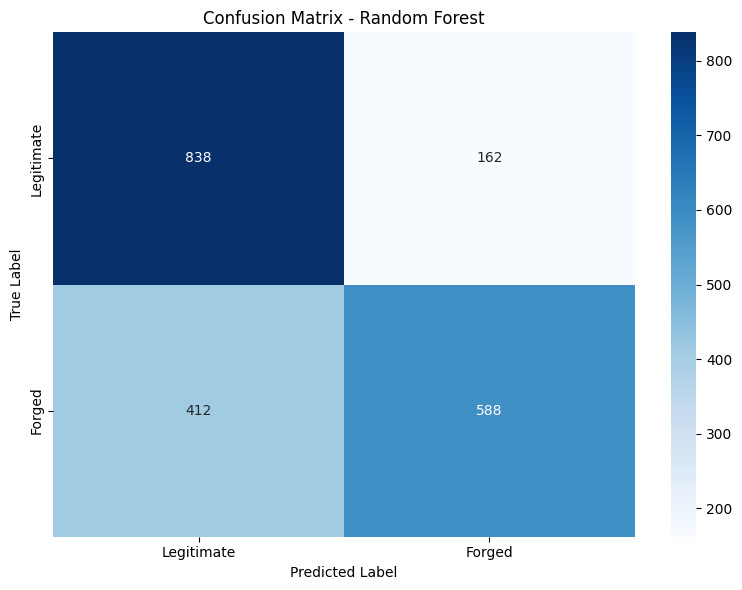

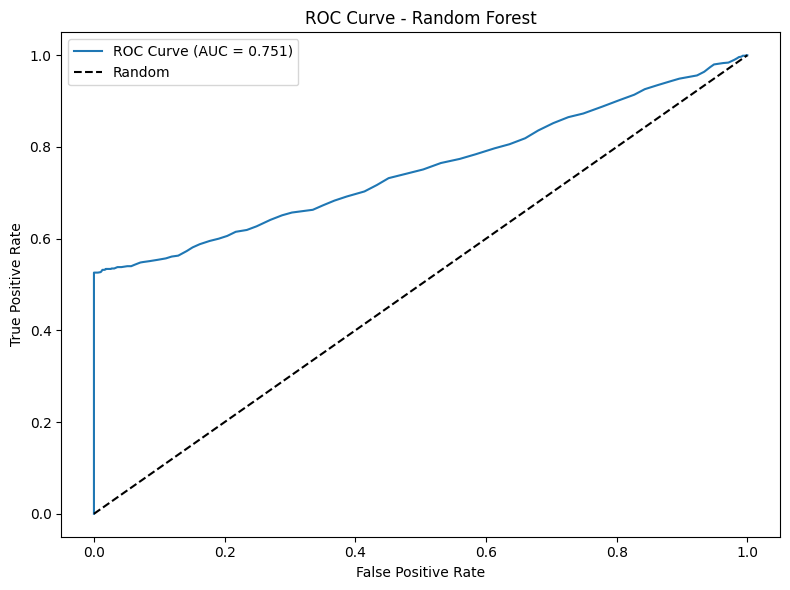

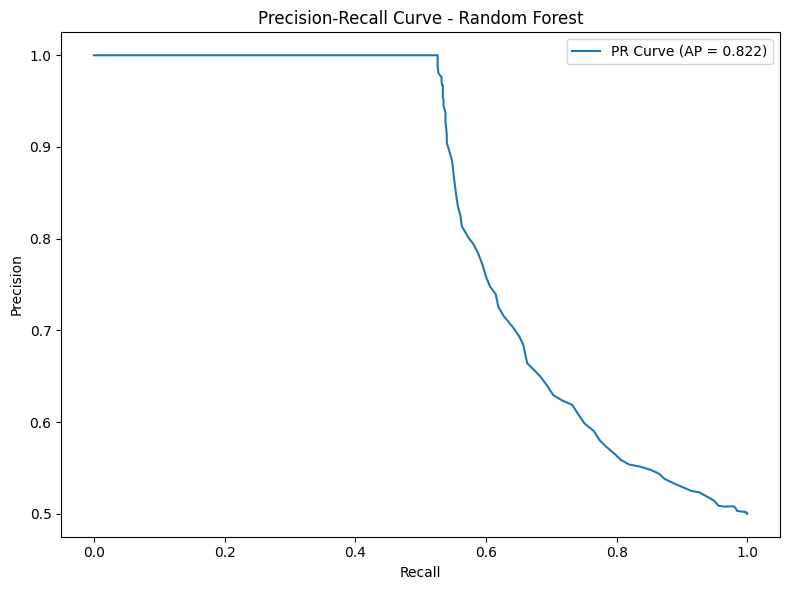

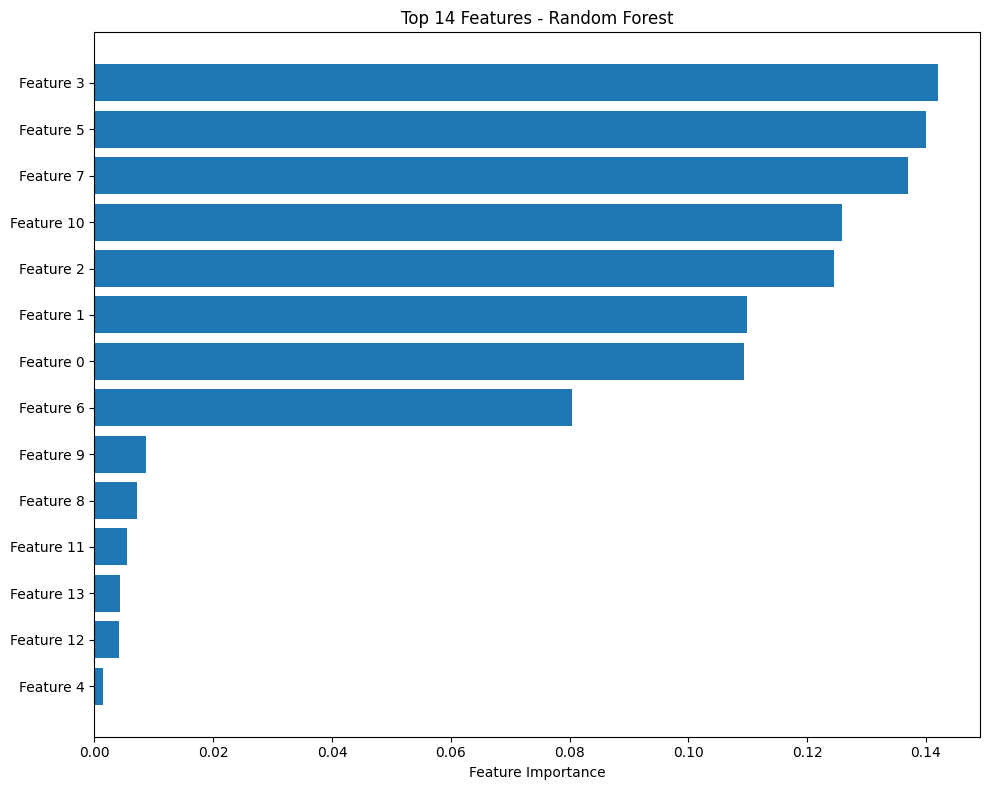

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
import time
import joblib

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test, preprocessor=None):
    """
    Train a Random Forest model on the data and evaluate its performance.

    Parameters:
    - X_train, X_test: Training and testing feature sets
    - y_train, y_test: Training and testing target values
    - preprocessor: Optional preprocessing pipeline (if X_train/X_test are not already processed)

    Returns:
    - Fitted Random Forest model
    - Dictionary of performance metrics
    """
    print("Training and evaluating Random Forest model...")

    # Initialize Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize results dictionary
    results = {
        'Accuracy': None,
        'Precision': None,
        'Recall': None,
        'F1 Score': None,
        'ROC AUC': None,
        'Training Time (s)': None,
        'Prediction Time (s)': None
    }

    # Create pipeline with preprocessor if provided
    if preprocessor is not None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Time training
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Store the fitted model
        fitted_model = pipeline

        # Time prediction
        start_time = time.time()
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        predict_time = time.time() - start_time

    else:
        # If data is already preprocessed
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Store the fitted model
        fitted_model = model

        # Time prediction
        start_time = time.time()
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        predict_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results['Accuracy'] = accuracy
    results['Precision'] = precision
    results['Recall'] = recall
    results['F1 Score'] = f1
    results['ROC AUC'] = roc_auc
    results['Training Time (s)'] = train_time
    results['Prediction Time (s)'] = predict_time

    # Print performance metrics
    print("\nRandom Forest Performance Metrics:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    # Print classification report
    print("\nClassification Report for Random Forest:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Forged'],
                yticklabels=['Legitimate', 'Forged'])
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_random_forest.png')

    # Create ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Random Forest')
    plt.legend()
    plt.tight_layout()
    plt.savefig('roc_curve_random_forest.png')

    # Create Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Random Forest')
    plt.legend()
    plt.tight_layout()
    plt.savefig('pr_curve_random_forest.png')

    # Feature importance for Random Forest
    if preprocessor is not None:
        # For pipeline
        feature_importances = fitted_model['classifier'].feature_importances_
        # Get feature names from preprocessor
        feature_names = fitted_model['preprocessor'].get_feature_names_out()
        feature_names = [name.split('__')[-1] for name in feature_names]
    else:
        # Direct model
        feature_importances = fitted_model.feature_importances_
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

    # Plot feature importance
    # Get top 15 features
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_idx = sorted_idx[:15]

    plt.figure(figsize=(10, 8))
    plt.barh([str(feature_names[i]) for i in top_idx],
             [feature_importances[i] for i in top_idx])

    plt.xlabel('Feature Importance')
    plt.title('Top 14 Features - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    # Save model
    joblib.dump(fitted_model, 'random_forest_model.pkl')

    return fitted_model, results

# If running as main script
if __name__ == "__main__":
    # Load preprocessed data
    X_train_processed = np.load("X_train_processed.npy")
    X_test_processed = np.load("X_test_processed.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")

    # Train and evaluate Random Forest model
    fitted_model, results = train_and_evaluate_random_forest(
        X_train_processed, X_test_processed, y_train, y_test
    )

    # Save results
    results_df = pd.DataFrame([results])
    results_df.to_csv("random_forest_results.csv", index=False)

    print("\nRandom Forest model training and evaluation complete.")
    print("Results saved to random_forest_results.csv")
    print("Model visualization plots saved.")

Evaluating Model Performance

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)
import joblib

def evaluate_model(model, X_test, y_test, df_original=None, feature_names=None):
    """
    Evaluate the trained Random Forest model

    Args:
        model: Trained Random Forest model
        X_test: Test features
        y_test: Test labels
        df_original: Original dataframe with all information (optional)
        feature_names: Names of the features (optional)
    """
    print("Evaluating Random Forest model performance...")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print("\nRandom Forest Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Forged']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Forged'],
                yticklabels=['Legitimate', 'Forged'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Random Forest')
    plt.tight_layout()
    plt.savefig('confusion_matrix_rf_eval.png')
    plt.close()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Random Forest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve_rf_eval.png')
    plt.close()

    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.axhline(y=sum(y_test)/len(y_test), color='red', linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Random Forest')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig('precision_recall_curve_rf_eval.png')
    plt.close()

    # Extract feature importances if the model has them
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'steps') and hasattr(model[-1], 'feature_importances_'):
        # For pipeline models
        feature_importances = model[-1].feature_importances_
    else:
        feature_importances = None

    # If we have feature names and importances, create the feature importance plot
    if feature_importances is not None:
        # If feature_names is not provided, try to get from the model
        if feature_names is None:
            if hasattr(model, 'feature_names_in_'):
                feature_names = model.feature_names_in_
            elif hasattr(X_test, 'columns'):
                feature_names = X_test.columns
            else:
                feature_names = [f'Feature {i}' for i in range(len(feature_importances))]

        # If feature_names is a list, convert it for easier indexing
        if not isinstance(feature_names, list):
            feature_names = list(feature_names)

        # Sort feature importances and get top features
        sorted_idx = np.argsort(feature_importances)[::-1]
        top_idx = sorted_idx[:15]  # Get top 15 features

        plt.figure(figsize=(10, 8))
        plt.barh([str(feature_names[i]) for i in top_idx],
                 [feature_importances[i] for i in top_idx])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Features - Random Forest')
        plt.tight_layout()
        plt.savefig('feature_importance_rf_eval.png')
        plt.close()

    # Save evaluation results to CSV
    results = {
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc],
        'PR AUC': [pr_auc]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('rf_evaluation_results.csv', index=False)

    # Forgery type analysis (if applicable)
    if df_original is not None and 'forgery_type' in df_original.columns:
        # Get the indices of test set
        test_indices = np.array(range(len(X_test)))

        # Map back to original dataframe to get forgery types
        # First, we need to create a dataframe with the test results
        test_results = pd.DataFrame({
            'y_true': y_test,
            'y_pred': y_pred,
            'y_prob': y_pred_proba
        })

        # Now create a new dataframe from the test set with predictions
        # Find the forged signatures in the test set
        forged_mask = y_test == 1
        forged_probs = y_pred_proba[forged_mask]
        forged_preds = y_pred[forged_mask]

        # Count the test set samples
        test_count = len(y_test)
        forged_test_count = sum(forged_mask)

        # Get stats from original dataset
        forgery_stats = df_original[df_original['is_forged'] == 1]['forgery_type'].value_counts(normalize=True)

        # Estimate the number of each type in test set
        estimated_counts = {ftype: int(forgery_stats[ftype] * forged_test_count)
                           for ftype in forgery_stats.index}

        # Print performance by estimated forgery type
        print("\nEstimated Performance by Forgery Type:")
        print(f"Total test samples: {test_count}")
        print(f"Forged test samples: {forged_test_count}")

        print("\nEstimated detection rates by forgery type:")
        for ftype, count in estimated_counts.items():
            print(f"  - {ftype}: ~{count} samples in test set")

    # Decision boundary visualization using top 2 features
    if feature_importances is not None and len(feature_importances) >= 2:
        # Get the top 2 most important features
        top_indices = np.argsort(feature_importances)[::-1][:2]

        # Extract the two features from the test data
        X_test_2d = X_test[:, top_indices]

        # Create a meshgrid for visualization
        h = 0.02  # step size in the mesh
        x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
        y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Create a dataset with just these two features
        X_mesh = np.c_[xx.ravel(), yy.ravel()]

        # Create a full feature set with zeros, and fill in the two features
        if hasattr(model, 'predict_proba'):
            # For direct models
            # We need to create a full-sized array filled with mean values
            X_full = np.zeros((X_mesh.shape[0], X_test.shape[1]))
            for i in range(X_test.shape[1]):
                X_full[:, i] = np.mean(X_test[:, i])

            # Now replace the two features we're visualizing
            X_full[:, top_indices[0]] = X_mesh[:, 0]
            X_full[:, top_indices[1]] = X_mesh[:, 1]

            # Predict probabilities
            Z = model.predict_proba(X_full)[:, 1]
            Z = Z.reshape(xx.shape)

            # Plot the decision boundary
            plt.figure(figsize=(12, 10))
            plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)

            # Plot the test points
            scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                                  c=y_test, cmap=plt.cm.RdBu_r, edgecolors='k')

            # Format and save the plot
            if feature_names and len(feature_names) > top_indices[0] and len(feature_names) > top_indices[1]:
                feature1_name = feature_names[top_indices[0]]
                feature2_name = feature_names[top_indices[1]]
            else:
                feature1_name = f'Feature {top_indices[0]}'
                feature2_name = f'Feature {top_indices[1]}'

            plt.xlabel(feature1_name)
            plt.ylabel(feature2_name)
            plt.title(f'Decision Boundary using {feature1_name} and {feature2_name}')
            plt.colorbar(scatter)
            plt.tight_layout()
            plt.savefig('decision_boundary_rf.png')
            plt.close()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

# If running as main script
if __name__ == "__main__":
    # Load the model and data
    try:
        # Try to load the best model from fine-tuning
        rf_model = joblib.load('best_random_forest_model.pkl')
        print("Loaded fine-tuned Random Forest model")
    except FileNotFoundError:
        # If not found, try to load the basic trained model
        try:
            rf_model = joblib.load('random_forest_model.pkl')
            print("Loaded base Random Forest model")
        except FileNotFoundError:
            print("Error: No Random Forest model found. Please train a model first.")
            exit(1)

    # Load test data
    X_test = np.load("X_test_processed.npy")
    y_test = np.load("y_test.npy")

    # Try to load original dataset for forgery type analysis
    try:
        df_original = pd.read_csv('digital_signature_dataset.csv')
        print("Loaded original dataset for detailed analysis")
    except FileNotFoundError:
        print("Original dataset not found. Will proceed without forgery type analysis.")
        df_original = None

    # Try to get feature names
    try:
        # Try to load feature names if they were saved
        feature_names = joblib.load('feature_names.pkl')
        print("Loaded feature names")
    except FileNotFoundError:
        # If feature names aren't available, use generic names
        feature_names = [f'Feature {i}' for i in range(X_test.shape[1])]
        print(f"Using generic feature names for {X_test.shape[1]} features")

    # Evaluate the model
    evaluation_results = evaluate_model(rf_model, X_test, y_test, df_original, feature_names)

    print("\nRandom Forest evaluation complete. Results saved to files:")
    print("- confusion_matrix_rf_eval.png")
    print("- roc_curve_rf_eval.png")
    print("- precision_recall_curve_rf_eval.png")
    print("- feature_importance_rf_eval.png (if feature importances available)")
    print("- decision_boundary_rf.png (if feature importances available)")
    print("- rf_evaluation_results.csv")

Loaded base Random Forest model
Loaded original dataset for detailed analysis
Using generic feature names for 14 features
Evaluating Random Forest model performance...

Random Forest Model Performance:
Accuracy: 0.7130
Precision: 0.7840
Recall: 0.5880
F1 Score: 0.6720
ROC AUC: 0.7514

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.67      0.84      0.74      1000
      Forged       0.78      0.59      0.67      1000

    accuracy                           0.71      2000
   macro avg       0.73      0.71      0.71      2000
weighted avg       0.73      0.71      0.71      2000


Estimated Performance by Forgery Type:
Total test samples: 2000
Forged test samples: 1000

Estimated detection rates by forgery type:
  - random: ~257 samples in test set
  - document_mismatch: ~256 samples in test set
  - weak_params: ~250 samples in test set
  - tampered: ~235 samples in test set

Random Forest evaluation complete. Results saved to files:
- c